# Experiments with different settings 

In [1]:
# Creating new experiment in Comet.ml
from comet_ml import Experiment
experiment = Experiment(
    api_key="VCyOxE7IjP9abOTTSwvn2gfs4",
    project_name="mri-segmentation",
    workspace="mrugnivenko",)

# Some necessary libs
import os
import sys
import glob
import torch
import torchio
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mrugnivenko/mri-segmentation/63bc8a8b42f14482966f847a4b1939b8



### Import functions from utils directory 

In [2]:
import imp

import utils.data_processor as data_processor
imp.reload(data_processor)
from utils.data_processor import *

import utils.visualization_tools as visualization_tools
imp.reload(visualization_tools)
from utils.visualization_tools import *

import utils.routine as routine
imp.reload(routine)
from utils.routine import *

import utils.metrics as metrics
imp.reload(metrics)
from utils.metrics import *

import utils.metrics_deep_mind as metrics_deep_mind
imp.reload(metrics_deep_mind)
from utils.metrics_deep_mind import *

import utils.visualization as visualization
imp.reload(visualization)
from utils.visualization import *
plot_volume = visualization.plot_volume_interactive

In [3]:
fcd_pirogov_seg_data = data_processor.DataMriSegmentation(sample = 'pirogov', prefix = 'fcd',
                         mask = 'combined', ignore_missing = True,
                         coord_min = (30,30,30, ), img_shape=(192, 192, 192, ),
                         image_path = '../datasets/fcd_classification_bank',
                         targets_path = 'targets/targets_fcd_bank.csv',
                         mask_path='../datasets/fcd_classification_bank/masks/combined/')


print('\n')
print(f'Dataset size: {len(fcd_pirogov_seg_data)}')
print(f'Labels distribution: {np.unique(fcd_pirogov_seg_data.target, return_counts=True)}\n')

#Example of data 
img, seg = fcd_pirogov_seg_data[1]
print(f'Image shape: {img.shape}')
print(f'Segmentation shape: {seg.shape}')

 13%|█▎        | 2/15 [00:00<00:00, 18.01it/s]

Assembling data for: pirogov sample.


100%|██████████| 15/15 [00:00<00:00, 21.40it/s]




Dataset size: 15
Labels distribution: (array([1]), array([15]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


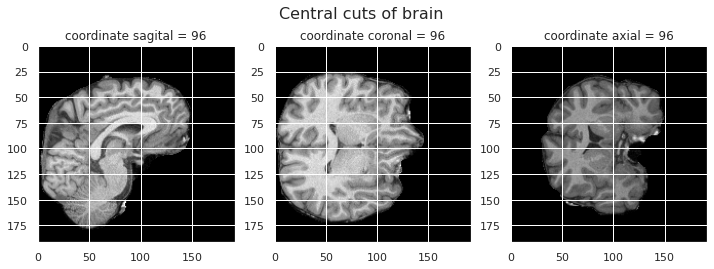

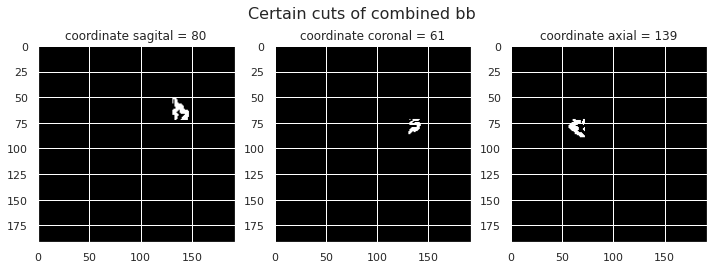

In [4]:
plot_central_cuts(img, 'brain')
plot_certain_cuts(seg, get_center_coord_of_bb(seg), 'combined bb')

### Preprocessing data

In [5]:
histogram_landmarks_path = 'landmarks/fcd_train_data_landmarks.npy'
# for recreating landmarks remove # below 
# image_paths = list(fcd_data.img_files[train_idx].values)
# landmarks = HistogramStandardization.train(image_paths, output_path=histogram_landmarks_path)
landmarks = np.load(histogram_landmarks_path)


training_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    #RandomBiasField(),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
#     RandomFlip(axes=(0,)),
#     OneOf({
#         RandomAffine(): 0.8,
#         RandomElasticDeformation(): 0.2,
#     }),
])

validation_transform = Compose([
    HistogramStandardization(landmarks={'MRI': landmarks}),
    ZNormalization(masking_method=ZNormalization.mean),
    CropOrPad((200, 200, 200)),
])

### Splitting data into train and test parts 

In [6]:
cv = ShuffleSplit(n_splits = 1,  test_size = 0.3, random_state = 42)
cv_splits = list(cv.split(X=np.arange(len(fcd_pirogov_seg_data)), y=fcd_pirogov_seg_data.target))

### Creating dataloaders for model 

In [7]:
training_loader, validation_loader = get_loaders(fcd_pirogov_seg_data, cv_splits[0],
        training_transform = training_transform,
        validation_transform = validation_transform)

Training set: 10 subjects
Validation set: 5 subjects
Mask type is combined


### Getting model and optimizer 

In [8]:
torch.cuda.empty_cache()

In [10]:
!nvidia-smi

Tue Feb 16 08:37:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   32C    P2    49W / 280W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
|  0%   36C    P2    68W / 280W |   7247MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [11]:
torch.cuda.set_device(0)

In [12]:
torch.cuda.current_device()

0

In [13]:
model, optimizer, scheduler = get_model_and_optimizer(device, out_channels_first_layer = 8)
model.load_state_dict(torch.load('weights/all_images_augm_seg_epoch_7.pth'))

<All keys matched successfully>

In [14]:
experiment.set_name("Pirogov FCD, combined mask, dice+ce loss")

Epoch 27 of 30 took 1208.909s
  training loss (in-iteration): 	0.642742
  validation loss: 			0.689641


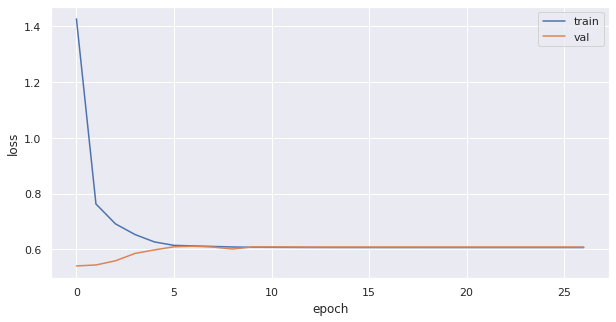

 90%|█████████ | 9/10 [00:31<00:03,  3.50s/it]

KeyboardInterrupt: 

In [17]:
torch.cuda.empty_cache()

training_params =  {
    'num_epochs': 30, 
    'training_loader': training_loader, 
    'validation_loader': validation_loader,
    'model': model, 
    'optimizer': optimizer,
    'scheduler': scheduler,
    'ratio': 1,
    'weights_stem':'pirogov_fcd_combined_masks_dice_ce_loss',
    'verbose':True,
    'save_epoch':1,
    'loss_type': 'dice+ce'
}

train(**training_params)

# Results

In [18]:
model, optimizer, scheduler = get_model_and_optimizer(device, out_channels_first_layer = 8)
model.load_state_dict(torch.load('weights/pirogov_fcd_combined_masks_dice_ce_loss_epoch_20.pth'))

<All keys matched successfully>

In [19]:
model.eval()

dice_scores = []
iou_scores = []
average_distances_gt_to_pred = []
average_distances_pred_to_gt = []

for batch in tqdm(validation_loader):
    inputs, targets = prepare_batch(batch, device)
    with torch.no_grad():
        logits = forward(model, inputs)
        probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
        prediction = probabilities.argmin(dim = 1)[0]
        ground_true  = targets[0,0,:]
        
    dice_scores.append(get_dice_score(targets, probabilities).mean().cpu().detach().numpy())
    iou_scores.append(get_iou_score(prediction.cpu().detach().numpy(), ground_true.cpu().detach().numpy()))
    
    average_distance_gt_to_pred, average_distance_pred_to_gt = compute_average_surface_distance(
        compute_surface_distances(
        ground_true.cpu().numpy().astype(np.uint8),
        prediction.cpu().numpy(), 
        spacing_mm=(1,1,1)
        )
    )
    average_distances_gt_to_pred.append(average_distance_gt_to_pred)
    average_distances_pred_to_gt.append(average_distance_pred_to_gt)
    
print('Mean dice score = ', np.mean(dice_scores))
print('Mean IoU score = ', np.mean(iou_scores))
print('Mean average distance gt to prediction = ', np.mean(average_distances_gt_to_pred))
print('Mean average distance prediction to gt = ', np.mean(average_distances_pred_to_gt))


100%|██████████| 5/5 [00:26<00:00,  5.40s/it]


Mean dice score =  0.48693176286272494
Mean IoU score =  0.000397669335705451
Mean average distance gt to prediction =  9.337959535633427
Mean average distance prediction to gt =  95.93468213124136


In [20]:
model.eval()

batch = next(iter(validation_loader))
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    logits = forward(model, inputs)
    probabilities = F.softmax(logits, dim = CHANNELS_DIMENSION)
pred = probabilities.argmin(dim = 1)[0]
seg  = targets[0,0,:]

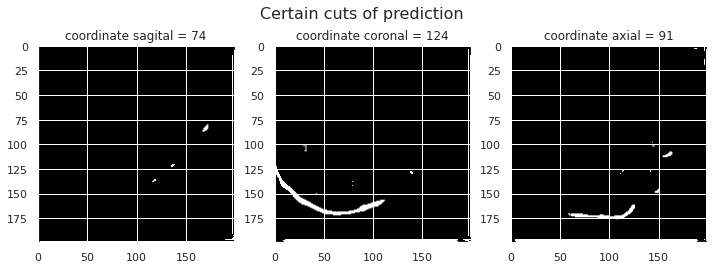

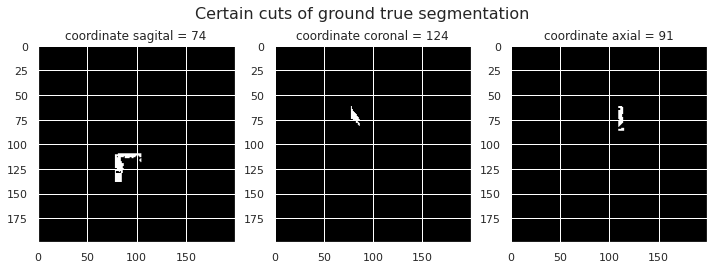

In [21]:
plot_certain_cuts(pred.cpu().detach().numpy(), get_center_coord_of_bb(seg.cpu().detach().numpy()), 'prediction')
plot_certain_cuts(seg.cpu().detach().numpy(), get_center_coord_of_bb(seg.cpu().detach().numpy()), 'ground true segmentation')